In [1]:
# Import stuff
import os
import scipy
from tqdm import tqdm, trange
from joblib import Parallel,delayed
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt

%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
figsize(11, 9)

os.chdir('/media/bigdata/firing_space_plot/ephys_data')
from ephys_data import ephys_data
import visualize

In [2]:
data_dir = '/media/bigdata/Abuzar_Data/AS18/AS18_4Tastes_200229_154608'
dat = \
    ephys_data(data_dir)
dat.firing_rate_params = dict(zip(\
    ('type', 'step_size','window_size','dt', 'baks_resolution', 'baks_dt'),
    ('conv',1,250,1,1e-3,1e-3)))

dat.get_unit_descriptors()
dat.get_spikes()
dat.get_firing_rates()

All tastes have equal dimensions,concatenating and normalizing


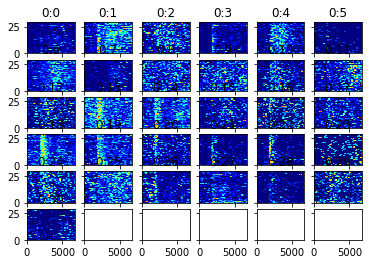

In [3]:
# Use MCMC changepoint separately on trials for single neuron
taste = 0
visualize.firing_overview(dat.firing_array[taste]);plt.show()

In [4]:
nrn = np.arange(10)
this_dat = dat.spikes[taste][:,nrn]
print(this_dat.shape)

(30, 10, 7000)


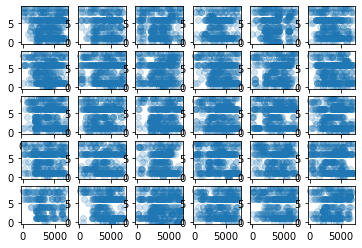

In [5]:
fig, ax = visualize.gen_square_subplots(this_dat.shape[0])
for num,this_ax in enumerate(ax.flatten()):
    spike_inds = np.where(this_dat[num])
    this_ax.scatter(spike_inds[1],spike_inds[0],alpha = 0.2)

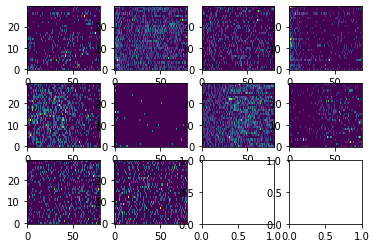

In [6]:
# Convert spikes to counts by binning
time_lims = [2000,6000]
bin_width = 50
t_vec = np.arange(this_dat.shape[-1])
binned_t_vec = np.mean(t_vec[time_lims[0]:time_lims[1]].reshape((-1,bin_width)),axis=-1)
this_dat_binned = np.sum(this_dat[...,time_lims[0]:time_lims[1]].reshape(*this_dat.shape[:2],-1,bin_width),axis=-1)
this_dat_binned = np.vectorize(np.int)(this_dat_binned)

fig, ax = visualize.gen_square_subplots(this_dat.shape[1])
for num,this_ax in enumerate(ax.flatten()):
    plt.sca(this_ax)
    if num < this_dat.shape[1]:
        visualize.imshow(this_dat_binned[:,num])

(10, 80)


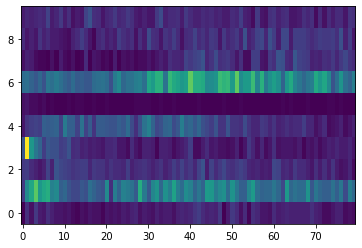

In [7]:
#trial = 0
#count_data = this_dat_binned[trial]
count_data = np.sum(this_dat_binned,axis=0)
n_count_data = count_data.shape[-1]
visualize.imshow(count_data)
print(count_data.shape)
#print('Average count = {}'.format(count_data.mean()))
#plt.bar(np.arange(n_count_data),count_data,color="#348ABD");plt.show()


In [8]:
split_array = np.array(np.array_split(count_data,2,axis=-1))
print(split_array.shape)
mean_vals = np.mean(split_array,axis=-1)
print(mean_vals)

(2, 10, 40)
[[ 4.35  26.2    9.475 10.475 17.775  0.65  26.6    3.275  6.9    7.75 ]
 [ 5.825 25.075  8.325  4.6    9.45   0.225 33.975  9.8   10.075  6.725]]


In [9]:
with pm.Model() as model:
    # Defining variables with priors
    alpha = 1.0/count_data.mean(axis=-1)  # Recall count_data is the
                                   # variable that holds our txt counts
    
    lambda_1 = pm.Exponential("lambda_1", alpha, testval = mean_vals[0], shape = (count_data.shape[0]))
    lambda_2 = pm.Exponential("lambda_2", alpha, testval = mean_vals[1], shape = (count_data.shape[0]))
    
    #tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data)
print(count_data.mean(axis=-1) )
print(lambda_1.tag.test_value)
print(lambda_2.tag.test_value)

[ 5.0875 25.6375  8.9     7.5375 13.6125  0.4375 30.2875  6.5375  8.4875
  7.2375]
[ 4.35  26.2    9.475 10.475 17.775  0.65  26.6    3.275  6.9    7.75 ]
[ 5.825 25.075  8.325  4.6    9.45   0.225 33.975  9.8   10.075  6.725]


In [10]:
with model:
    idx = np.arange(n_count_data) # Index
    
    #tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data)
    
    # Scaled beta mixture "somewhere in the middle" prior
    a = pm.HalfNormal('a_hp', 3.)
    b = pm.HalfNormal('b_hp', 3.)
    tau_latent = pm.Beta('tau_latent', a, b)
    tau = pm.Deterministic('tau', idx.min() + (idx.max() - idx.min()) * tau_latent)
    
    print(tau.tag.test_value)
    


39.5


In [11]:
with model:
    #lambda_ = pm.math.stack(
    #            [pm.math.switch(tau >= idx, lambda_1[i], lambda_2[i]) \
    #                            for i in range(count_data.shape[0])]
    #                        )
    
    weight = tt.nnet.sigmoid(2 * (idx - tau))
    lambda_ = pm.math.stack(
                [(1-weight) * lambda_1[i] + weight * lambda_2[i] \
                 for i in range(count_data.shape[0])]
                        )
    
print(lambda_.tag.test_value.shape)

(10, 80)


In [12]:
with model:
    observation = pm.Poisson("obs", lambda_, observed=count_data)
    

In [13]:
with model:
    #step = pm.Metropolis()
    #trace = pm.sample(15000, tune=5000,step=step)
    trace = pm.sample(15000, tune=5000, chains = 8, cores = 8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [tau_latent, b_hp, a_hp, lambda_2, lambda_1]
Sampling 8 chains, 0 divergences: 100%|██████████| 160000/160000 [01:00<00:00, 2651.27draws/s]


In [14]:
pm.summary(trace).round(2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
lambda_1[0],4.14,0.37,3.47,4.84,0.0,0.0,230584.0,225813.0,229880.0,87769.0,1.0
lambda_1[1],25.28,0.91,23.59,27.01,0.0,0.0,233079.0,231980.0,233048.0,86981.0,1.0
lambda_1[2],9.61,0.56,8.57,10.69,0.0,0.0,227942.0,225708.0,227736.0,88459.0,1.0
lambda_1[3],12.27,0.64,11.08,13.49,0.0,0.0,191652.0,188587.0,194625.0,86777.0,1.0
lambda_1[4],17.31,0.76,15.87,18.74,0.0,0.0,223453.0,222483.0,223227.0,87561.0,1.0
lambda_1[5],0.75,0.15,0.47,1.03,0.0,0.0,228464.0,204235.0,227375.0,84281.0,1.0
lambda_1[6],23.11,0.90,21.40,24.77,0.0,0.0,215743.0,214891.0,215740.0,91077.0,1.0
lambda_1[7],2.29,0.28,1.79,2.82,0.0,0.0,230373.0,221010.0,229906.0,87117.0,1.0
lambda_1[8],6.51,0.47,5.64,7.40,0.0,0.0,203138.0,202279.0,201992.0,86453.0,1.0
lambda_1[9],7.55,0.50,6.64,8.51,0.0,0.0,215405.0,213264.0,214986.0,86320.0,1.0


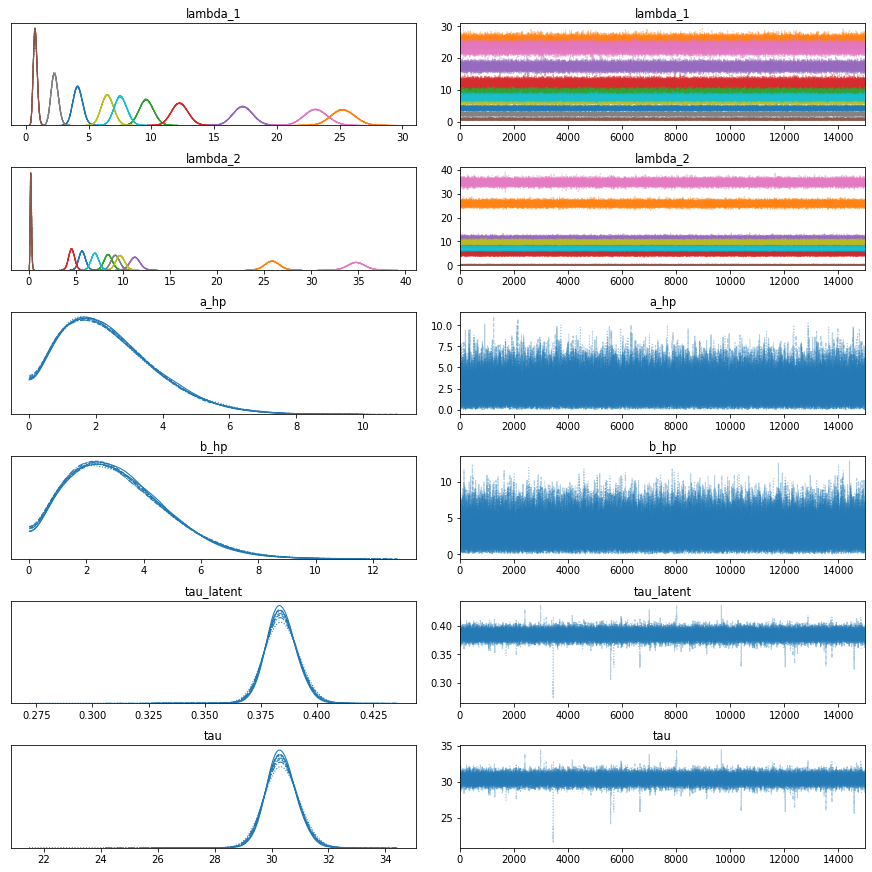

In [15]:
pm.traceplot(trace);

In [18]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

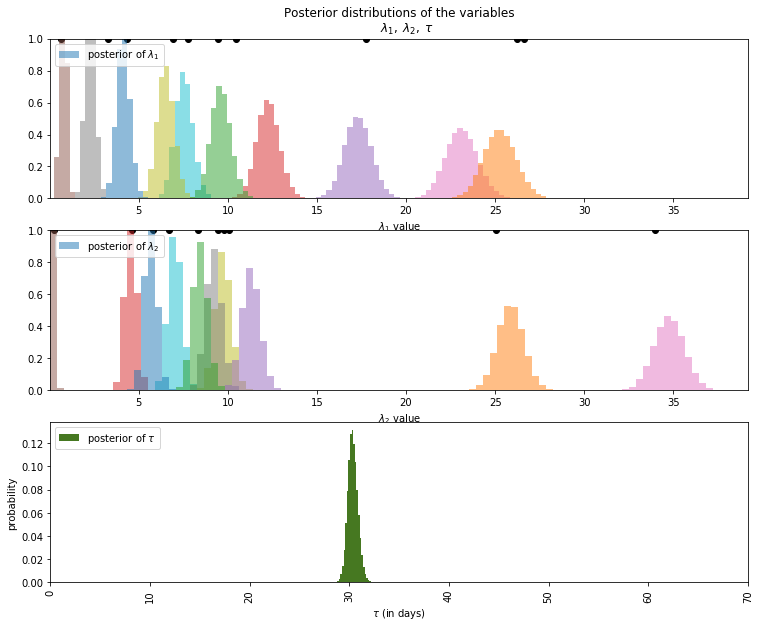

In [19]:
figsize(12.5, 10)
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)
collected_samples = np.concatenate([lambda_1_samples.flatten(),lambda_2_samples.flatten()])
x_lims = [min(collected_samples),max(collected_samples)]
bin_num = 100

plt.hist(lambda_1_samples, histtype='stepfilled', bins=bin_num, alpha=0.5,
         label="posterior of $\lambda_1$", density=True)
plt.scatter(mean_vals[0], np.ones(mean_vals[0].shape),c='k')
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlabel("$\lambda_1$ value")
plt.xlim(x_lims)

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=bin_num, alpha=0.5,
         label="posterior of $\lambda_2$", density=True)
plt.scatter(mean_vals[1], np.ones(mean_vals[1].shape),c='k')
plt.legend(loc="upper left")
plt.xlabel("$\lambda_2$ value")
plt.xlim(x_lims)


plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data,step=10))


plt.legend(loc="upper left")
plt.xlabel(r"$\tau$ (in days)")
plt.xticks(rotation='vertical')
plt.ylabel("probability");

In [20]:
ppc = pm.sample_posterior_predictive(trace, samples = 10000, model = model)
ppc['obs'].shape

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 10000/10000 [00:14<00:00, 709.31it/s]


(10000, 10, 80)

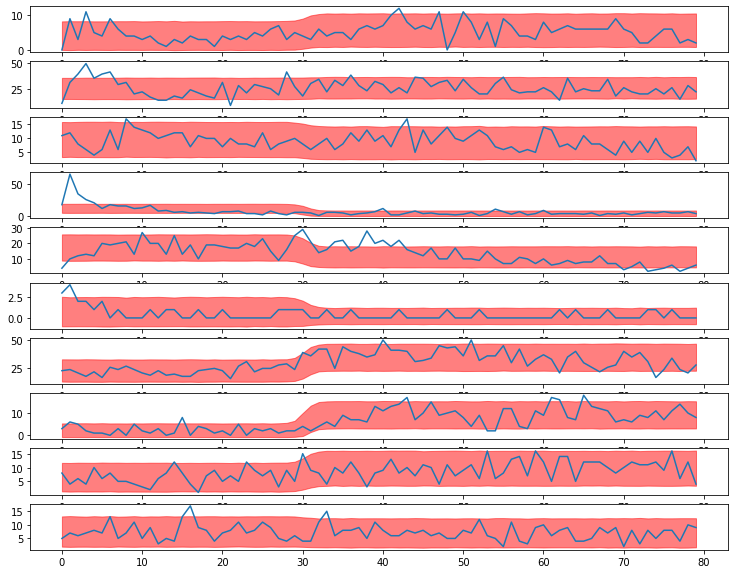

In [24]:
mean_ppc = np.mean(ppc['obs'],axis=0)
std_ppc = np.std(ppc['obs'],axis=0)

x = np.arange(count_data.shape[-1])
fig, ax = plt.subplots(count_data.shape[0],1, sharey = False)
for num,(nrn,this_ax) in enumerate(zip(count_data, ax.flatten())):
    this_ax.plot(x,nrn);
    this_ax.fill_between( x = x,
                        y1 = mean_ppc[num] + 2*std_ppc[num],
                        y2 = mean_ppc[num] - 2*std_ppc[num],
                        color = 'red', alpha = 0.5);
#plt.plot(np.mean(ppc['obs'],axis=0));
#traces = 100
#plt.plot(ppc['obs'][:100].T, alpha = 0.05);

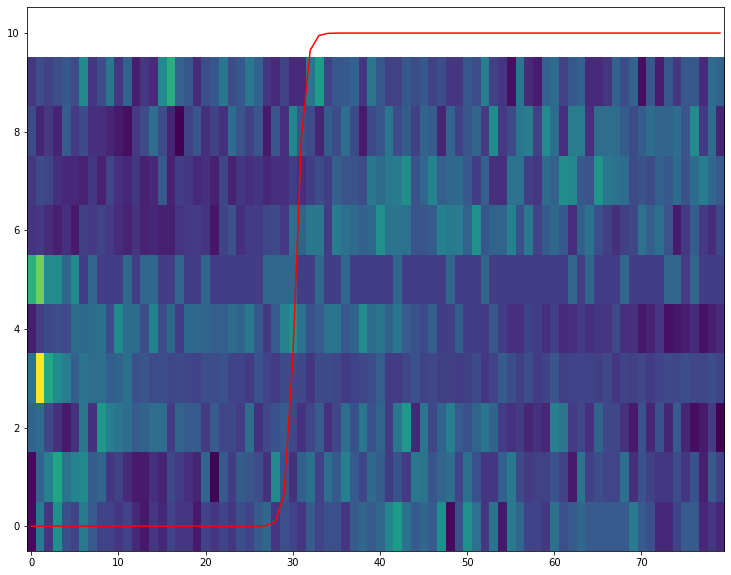

In [25]:
visualize.imshow(stats.zscore(count_data,axis=-1))
state_prob = 1 - 1/(1+np.exp((2 * (x - np.mean(tau_samples)))))
plt.plot(x,state_prob*count_data.shape[0], c = 'red')